In [6]:
import pandas as pd
import torch
from tqdm import tqdm
# import faiss
import math
import numpy as np
from numpy import dot
from numpy.linalg import norm

# from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, StandardScaler
from sklearn.metrics import accuracy_score, RocCurveDisplay, log_loss
from sklearn.metrics.pairwise import cosine_similarity

import xgboost

import pickle

In [7]:
# Maket path to save models
os.makedirs('models/classification', exist_ok=True)
model_path = 'models/classification'

# Maket path to save results to compare types of model
os.makedirs('results_to_eval/top_20_accuracy', exist_ok=True)
top20acc_path = 'results_to_eval/top_20_accuracy'

os.makedirs('results_to_eval/top_20_wines', exist_ok=True)
top20wines_path = 'results_to_eval/top_20_wines'

os.makedirs('results_to_eval/top_3_styles', exist_ok=True)
top3styles_path = 'results_to_eval/top_3_styles'

# Intialize embedding model

In [29]:
from langchain.embeddings.openai import OpenAIEmbeddings
import openai
import tiktoken

# get API key from OpenAI website
OPENAI_API_KEY = "OPENAI_API_KEY"
openai.api_key = os.getenv("OPENAI_API_KEY") or OPENAI_API_KEY

# Initialize the SentenceTransformer model
model_name = 'text-embedding-ada-002'

embed_model = OpenAIEmbeddings(
    model=model_name,
    openai_api_key=OPENAI_API_KEY
)

# Load embedding data

In [10]:
# Load original dataset
wine = pd.read_csv('../Data/Cleaned Data/wine_cleaned_rev_concat.csv', encoding='utf-8')
wine.rename(columns={'Unnamed: 0': 'id'}, inplace=True)
print(wine.shape)
print(wine.columns)

(84502, 14)
Index(['id', 'country', 'description', 'designation', 'points', 'price',
       'province', 'title', 'variety', 'winery', 'region_cleaned', 'style1',
       'style2', 'style3'],
      dtype='object')


In [11]:
# Load embeddings
embeddings = torch.load("../Data/description_embeddings_openai_ada-002.pt") 
print(embeddings.shape)

torch.Size([84502, 1536])


In [12]:
# Join the wine dataset with embeddings
df_embeddings = pd.DataFrame(embeddings.numpy())
wine_emb = pd.concat([wine, df_embeddings], axis=1)

# Drop if a style has <200 reviews

In [13]:
# Combine wine df and embeddings df
df_embeddings = pd.DataFrame(embeddings.numpy())
wine_emb = pd.concat([wine, df_embeddings], axis=1)

In [14]:
# Drop if a style has <80 reviews 
tab_by_style = wine_emb.groupby('style3')['id'].count().reset_index()
tab_by_style.rename(columns={'id':'count'}, inplace=True)

styles_to_drop = tab_by_style[tab_by_style['count']>=200]['style3'].to_list()

wine_emb = wine_emb[wine_emb['style3'].isin(styles_to_drop)].reset_index(drop=True)

# Train-test split

In [15]:
# Split - stratify by 'style2'
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(wine_emb[wine_emb.columns[-384:]], 
                                                                          wine_emb['style3'], 
                                                                          wine_emb.index,
                                                                          test_size = 0.1,
                                                                          random_state = 524, 
                                                                          stratify = wine_emb['style3'])

In [16]:
# Scaling
scaler = StandardScaler()
scaler.fit(X_train) 
X_train_scale = scaler.transform(X_train) 
X_test_scale =  scaler.transform(X_test)

In [17]:
# Encode the styles
lb = LabelEncoder()
y_train_code = lb.fit_transform(y_train)
y_test_code = lb.transform(y_test)

# Define Useful functions

In [18]:
# Define topk_accuracy function
def topk_accuracy(N, pred_probs_matrix, y_code_vector):
    """Compute top-k accuracy score, given predicted probabilities (matrix) and the target column (vector)."""
    accuracy=[]
    idx_sort_matrix = np.argsort(pred_probs_matrix)
    
    for n in range(1,N+1):
        # Sort desc and only extract the top-N
        top_n_matrix = idx_sort_matrix[:,:-n-1:-1]
    
        # Calculate accuracy
        true_preds = 0
        for i in range(len(y_code_vector)):
            if y_code_vector[i] in top_n_matrix[i]:
                true_preds += 1
        
        accuracy_n= true_preds/len(y_code_vector)
        accuracy.append(accuracy_n)
    return accuracy

In [19]:
# Define Softmax function
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

In [20]:
# Define find_topk_styles function
def find_topk_styles(N, pred_probs_vector):
    """Find k styles of wine with the highest predicted probabilities."""
    idx_sort_vector = np.argsort(pred_probs_vector)    
    top_n_vector = idx_sort_vector[:,:-N-1:-1]
    return lb.inverse_transform(top_n_vector[0])

In [21]:
# Define find_topk_wines function
def find_topk_wines(N, wine_data, score_vector):
    """Find k wines from a wine database with the highest similarity score to the user's input."""
    idx_sort_vector = np.argsort(score_vector.reshape(-1))    
    top_n_vector = idx_sort_vector[:-N-1:-1]
    top_n_df = wine_data.iloc[top_n_vector, :][['title', 'description']].copy()
    top_n_df['score'] = score_vector[top_n_vector]
    top_n_df.columns = ['Title', 'Description', 'Similarity Score']
    return top_n_df

# Logistic Regression

In [16]:
from sklearn.linear_model import LogisticRegression

In [17]:
# Fit - use the default solver with L2-penalty - tune the extent of regularization with C
classifier = LogisticRegression(multi_class='multinomial', max_iter=500)
hyper_param = {'C':[0.01, 0.1, 1, 10]}

# GridSearchCV 
grid_cv = GridSearchCV(classifier,
                       param_grid = hyper_param,
                       scoring = 'neg_log_loss', 
                       n_jobs = 16,
                       cv = 5)

grid_cv.fit(X_train_scale, y_train_code)

GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=500,
                                          multi_class='multinomial'),
             n_jobs=16, param_grid={'C': [0.01, 0.1, 1, 10]},
             scoring='neg_log_loss')

In [18]:
# Show best hyper parameters
grid_cv.best_params_

{'C': 0.01}

In [19]:
# See CV results
grid_cv.cv_results_

{'mean_fit_time': array([ 95.73623095, 173.42757215, 173.54839125, 129.89521523]),
 'std_fit_time': array([ 3.75728954,  0.79431876,  0.8531166 , 21.36972279]),
 'mean_score_time': array([0.10769114, 0.07419   , 0.08551769, 0.05279756]),
 'std_score_time': array([0.00679265, 0.02034741, 0.0242867 , 0.02334673]),
 'param_C': masked_array(data=[0.01, 0.1, 1, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.01}, {'C': 0.1}, {'C': 1}, {'C': 10}],
 'split0_test_score': array([-1.37774617, -1.46670609, -2.03366676, -3.1438833 ]),
 'split1_test_score': array([-1.38145119, -1.48613537, -2.08070377, -3.13153351]),
 'split2_test_score': array([-1.39352466, -1.50857165, -2.11366002, -3.25802415]),
 'split3_test_score': array([-1.40325572, -1.50979395, -2.12542607, -3.21406096]),
 'split4_test_score': array([-1.41727049, -1.52467128, -2.12676493, -3.23214407]),
 'mean_test_score': array([-1.39464964, -1.49917567, -2.09604

In [20]:
# Save best model using pickle 
with open(model_path + '/logistic.pkl','wb') as f:
    pickle.dump(grid_cv.best_estimator_, f)

# load model
with open(model_path + '/logistic.pkl', 'rb') as f:
    clf = pickle.load(f)

## Evaluate train performance

In [21]:
# Predict: best_estimator_=True by default
pred_train = clf.predict(X_train_scale)

In [22]:
# Accuracy of train
print("Train accuracy score:", clf.score(X_train_scale, y_train_code))

probs_train = clf.predict_proba(X_train_scale)

Train accuracy score: 0.6893834763511218


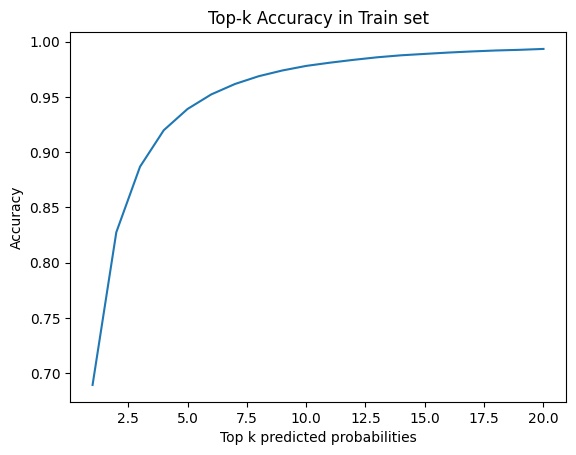

In [23]:
# Top-20 accuracy in train
probs_train = clf.predict_proba(X_train_scale)

top20_accuracy = topk_accuracy(20, probs_train, y_train_code)

sns.lineplot(x=range(1,21), y=top20_accuracy) 
plt.xlabel("Top k predicted probabilities")
plt.ylabel("Accuracy")
plt.title("Top-k Accuracy in Train set")
plt.show()

In [24]:
# Save top-20 accuracy on train set
top20_accuracy = topk_accuracy(20, probs_train, y_train_code)
top20_accuracy_df = pd.DataFrame(top20_accuracy, columns=['train'])
top20_accuracy_df['model'] = 'Multinomial Logistic'

## Evaluate test performance

In [25]:
# Accuracy test
print("Test accuracy score:", clf.score(X_test_scale, y_test_code))

probs_test = clf.predict_proba(X_test_scale)

Test accuracy score: 0.5971882640586798


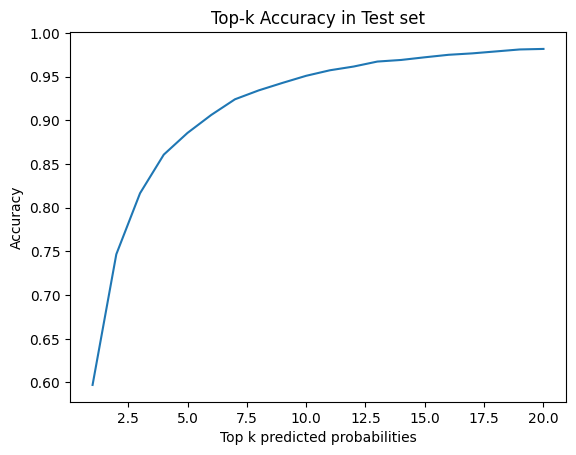

In [26]:
# Top-20 accuracy in test
probs_test = clf.predict_proba(X_test_scale)

top20_accuracy1 = topk_accuracy(20, probs_test, y_test_code)

sns.lineplot(x=range(1,21), y=top20_accuracy1) 
plt.xlabel("Top k predicted probabilities")
plt.ylabel("Accuracy")
plt.title("Top-k Accuracy in Test set")
plt.show()

In [27]:
# Save top-20 accuracy on test set
top20_accuracy_df['test'] = topk_accuracy(20, probs_test, y_test_code)
top20_accuracy_df = top20_accuracy_df[['model', 'train', 'test']]
top20_accuracy_df.to_csv(top20acc_path + '/logistic.csv')

# Support Vector Machine

In [28]:
from sklearn.svm import LinearSVC, SVC

In [29]:
classifier = LinearSVC(  multi_class='ovr', dual='auto', max_iter=100)

# classifier = SVC(  kernel='linear', probability=True, random_state=463, max_iter=100
#                  # break_ties=True
#                 )
# Note: allow 'probability' predictions, in doing so also add 'random state' because SVC predicts probabilities by doing an internal CV)
# Note: add 'break tie' to break ties among the tied classes (quire important for multiclass, but increase computation cost)

hyper_param = {'C':[0.01, 0.1, 1]}

# GridSearchCV 
grid_cv = GridSearchCV(classifier,
                       param_grid = hyper_param,
                       scoring = 'accuracy',
                       n_jobs = 16,
                       cv = 5)

grid_cv.fit(X_train_scale, y_train_code)


GridSearchCV(cv=5, estimator=LinearSVC(dual='auto', max_iter=100), n_jobs=16,
             param_grid={'C': [0.01, 0.1, 1]}, scoring='accuracy')

In [30]:
# Show best hyper parameters
grid_cv.best_params_

{'C': 0.01}

In [31]:
# See CV results
grid_cv.cv_results_

{'mean_fit_time': array([599.51139135, 592.39423642, 620.42605143]),
 'std_fit_time': array([3.02159094, 5.555136  , 2.58702995]),
 'mean_score_time': array([0.05065193, 0.06775222, 0.02517209]),
 'std_score_time': array([0.01235185, 0.00797441, 0.00223286]),
 'param_C': masked_array(data=[0.01, 0.1, 1],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.01}, {'C': 0.1}, {'C': 1}],
 'split0_test_score': array([0.57086258, 0.55863708, 0.52909214]),
 'split1_test_score': array([0.57539054, 0.55976907, 0.53554449]),
 'split2_test_score': array([0.56753085, 0.55281331, 0.52564248]),
 'split3_test_score': array([0.56458734, 0.55054908, 0.52598211]),
 'split4_test_score': array([0.56005887, 0.54726593, 0.5220197 ]),
 'mean_test_score': array([0.56768604, 0.5538069 , 0.52765618]),
 'std_test_score': array([0.00523926, 0.00475948, 0.00453684]),
 'rank_test_score': array([1, 2, 3])}

In [32]:
# Save best model using pickle 
with open(model_path + '/linearsvc.pkl','wb') as f:
    pickle.dump(grid_cv.best_estimator_, f)


# load model
with open(model_path + '/linearsvc.pkl', 'rb') as f:
    clf = pickle.load(f)

## Evaluate train performance

In [33]:
# Accuracy of train
print("Train Accuracy score:", clf.score(X_train_scale, y_train_code))

Train Accuracy score: 0.6707722960581429


In [34]:
# Predict: best_estimator_=True by default
pred_train = clf.predict(X_train_scale)

# Predit confidence score --> to be converted to probabilities
confidence_score_train = clf.decision_function(X_train_scale)

In [35]:
# Compute predicted probabilities after softmax
probs_train = np.zeros_like(confidence_score_train)

for i, j in enumerate(confidence_score_train): 
    probs_train[i]= softmax(j)

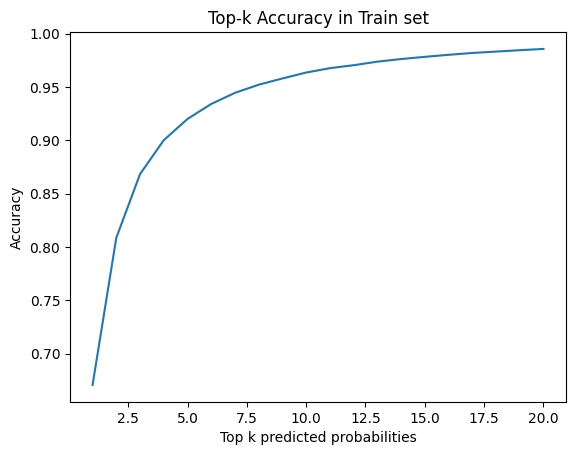

In [36]:
# Top-20 accuracy in train
top20_accuracy = topk_accuracy(20, probs_train, y_train_code)

sns.lineplot(x=range(1,21), y=top20_accuracy) 
plt.xlabel("Top k predicted probabilities")
plt.ylabel("Accuracy")
plt.title("Top-k Accuracy in Train set")
plt.show()

In [37]:
# Save top-20 accuracy on train set
top20_accuracy = topk_accuracy(20, probs_train, y_train_code)
top20_accuracy_df = pd.DataFrame(top20_accuracy, columns=['train'])
top20_accuracy_df['model'] = 'Linear SVC'


## Evaluate test performance

In [38]:
# Accuracy test
print("Test accuracy score:", clf.score(X_test_scale, y_test_code))

Test accuracy score: 0.5751833740831296


In [39]:
# Predict: best_estimator_=True by default
pred_test = clf.predict(X_test_scale)

# Predit confidence score --> to be converted to probabilities
confidence_score_test = clf.decision_function(X_test_scale)

In [40]:
# Compute predicted probabilities after softmax
probs_test = np.zeros_like(confidence_score_test)

for i, j in enumerate(confidence_score_test): 
    probs_test[i]= softmax(j)

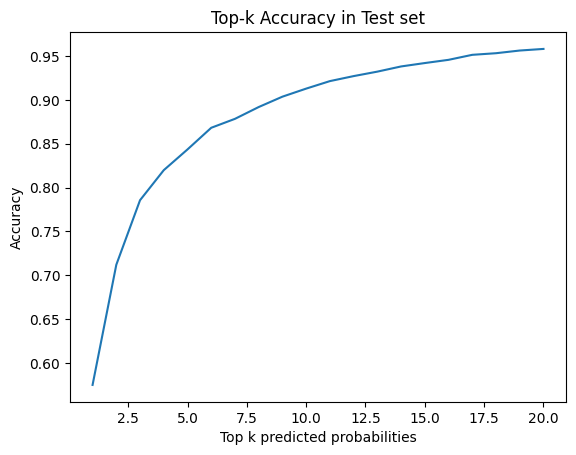

In [41]:
# Top-20 accuracy in test
top20_accuracy1 = topk_accuracy(20, probs_test, y_test_code)

sns.lineplot(x=range(1,21), y=top20_accuracy1) 
plt.xlabel("Top k predicted probabilities")
plt.ylabel("Accuracy")
plt.title("Top-k Accuracy in Test set")
plt.show()

In [42]:
# Save top-20 accuracy on test set
top20_accuracy_df['test'] = topk_accuracy(20, probs_test, y_test_code)
top20_accuracy_df = top20_accuracy_df[['model', 'train', 'test']]
top20_accuracy_df.to_csv(top20acc_path + '/linearsvc.csv')

# Random Forest

In [43]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [44]:
classifier = RandomForestClassifier(random_state = 614, 
                                    max_samples=round(0.5*len(y_train_code)), 
                                    class_weight='balanced', 
                                    n_jobs = 16)

# By default, boostraping with replacement will yield 2/3*N observations for each tree
# Use default n_estimators = 100

hyper_param = {'max_depth':[5, 10, 15], 'n_estimators':[500, 750, 1000]}

# GridSearchCV - stratifiedKFold is used by default
grid_cv = GridSearchCV(classifier,
                       param_grid = hyper_param,
                       scoring = 'neg_log_loss',
                       cv = 5)

grid_cv.fit(X_train_scale, y_train_code)


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              max_samples=22084, n_jobs=16,
                                              random_state=614),
             param_grid={'max_depth': [5, 10, 15],
                         'n_estimators': [500, 750, 1000]},
             scoring='neg_log_loss')

In [45]:
# Show best hyper parameters
grid_cv.best_params_

{'max_depth': 15, 'n_estimators': 1000}

In [46]:
# See CV results
grid_cv.cv_results_

{'mean_fit_time': array([ 24.35211868,  36.41745853,  48.03937397,  47.44386983,
         70.6867837 ,  93.82236824,  67.8012682 , 101.36394873,
        136.12707438]),
 'std_fit_time': array([0.14490158, 0.18768751, 0.16016365, 0.22765056, 0.38282757,
        0.24958231, 0.43825855, 0.8014496 , 1.634019  ]),
 'mean_score_time': array([0.63534451, 0.87613697, 1.18024154, 0.63497128, 0.96386795,
        1.32655063, 0.77635474, 1.01594791, 1.38045692]),
 'std_score_time': array([0.03908147, 0.02722215, 0.02596787, 0.0093265 , 0.02972107,
        0.01695735, 0.02484738, 0.02667623, 0.04107031]),
 'param_max_depth': masked_array(data=[5, 5, 5, 10, 10, 10, 15, 15, 15],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[500, 750, 1000, 500, 750, 1000, 500, 750, 1000],
              mask=[False, False, False, False, False, False, False, False,
    

In [47]:
# Save best model using pickle 
with open(model_path + '/rf.pkl','wb') as f:
    pickle.dump(grid_cv.best_estimator_, f)

# load model
with open(model_path + '/rf.pkl', 'rb') as f:
    clf = pickle.load(f)

## Evaluate train performance

In [48]:
# Accuracy of train
print("Train Accuracy score:", clf.score(X_train_scale, y_train_code))

Train Accuracy score: 0.9909434645776258


In [49]:
# Predict: best_estimator_=True by default
pred_train = clf.predict(X_train_scale)

# Predit probabilities
probs_train = clf.predict_proba(X_train_scale)

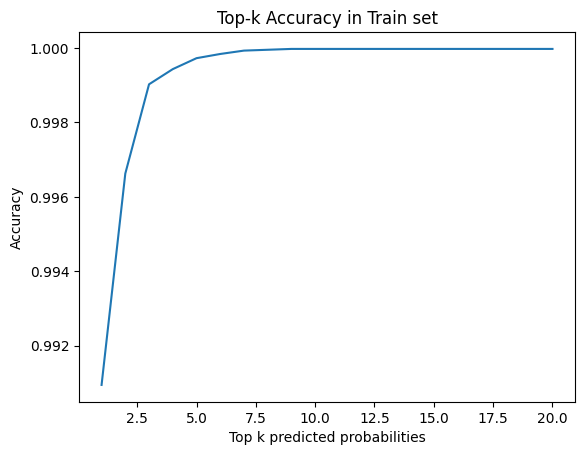

In [50]:
# Top-20 accuracy in train
top20_accuracy = topk_accuracy(20, probs_train, y_train_code)

sns.lineplot(x=range(1,21), y=top20_accuracy) 
plt.xlabel("Top k predicted probabilities")
plt.ylabel("Accuracy")
plt.title("Top-k Accuracy in Train set")
plt.show()

In [51]:
# Save top-20 accuracy on train set
top20_accuracy = topk_accuracy(20, probs_train, y_train_code)
top20_accuracy_df = pd.DataFrame(top20_accuracy, columns=['train'])
top20_accuracy_df['model'] = 'Random Forest'

## Evaluate test performance

In [52]:
# Accuracy test
print("Test accuracy score:", clf.score(X_test_scale, y_test_code))

Test accuracy score: 0.45843520782396086


In [53]:
# Predict: best_estimator_=True by default
pred_test = clf.predict(X_test_scale)

# Predit  probabilities
probs_test = clf.predict_proba(X_test_scale)

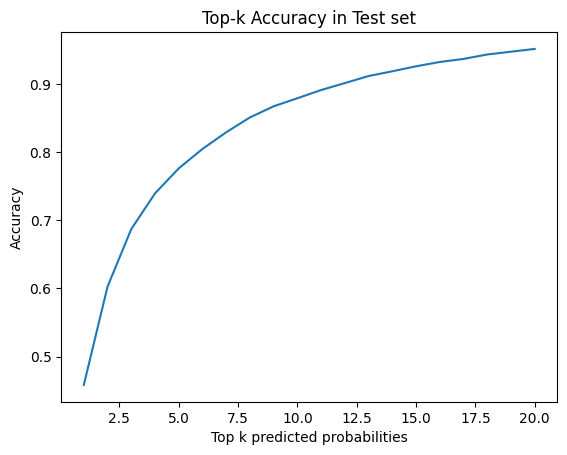

In [54]:
# Top-20 accuracy in test
top20_accuracy = topk_accuracy(20, probs_test, y_test_code)

sns.lineplot(x=range(1,21), y=top20_accuracy) 
plt.xlabel("Top k predicted probabilities")
plt.ylabel("Accuracy")
plt.title("Top-k Accuracy in Test set")
plt.show()

In [55]:
# Save top-20 accuracy on test set
top20_accuracy_df['test'] = topk_accuracy(20, probs_test, y_test_code)
top20_accuracy_df = top20_accuracy_df[['model', 'train', 'test']]
top20_accuracy_df.to_csv(top20acc_path + '/rf.csv')

# XGBoost

In [56]:
from xgboost import XGBClassifier

In [57]:
# Fit model
XGBclf = XGBClassifier(n_estimators=1000, 
                       verbosity=1, 
                       nthread = 16,
                       eval_metric = 'mlogloss', 
                       learning_rate = 0.1,
                       early_stopping_rounds = 10)

XGBclf.fit(X_train_scale, y_train_code,
           eval_set=[(X_test_scale, y_test_code)] )

[0]	validation_0-mlogloss:3.95728
[1]	validation_0-mlogloss:3.74553
[2]	validation_0-mlogloss:3.58925
[3]	validation_0-mlogloss:3.46426
[4]	validation_0-mlogloss:3.35622
[5]	validation_0-mlogloss:3.26168
[6]	validation_0-mlogloss:3.18070
[7]	validation_0-mlogloss:3.10729
[8]	validation_0-mlogloss:3.03890
[9]	validation_0-mlogloss:2.97614
[10]	validation_0-mlogloss:2.91928
[11]	validation_0-mlogloss:2.86740
[12]	validation_0-mlogloss:2.81835
[13]	validation_0-mlogloss:2.77309
[14]	validation_0-mlogloss:2.73129
[15]	validation_0-mlogloss:2.69282
[16]	validation_0-mlogloss:2.65636
[17]	validation_0-mlogloss:2.62184
[18]	validation_0-mlogloss:2.58920
[19]	validation_0-mlogloss:2.55852
[20]	validation_0-mlogloss:2.53042
[21]	validation_0-mlogloss:2.50304
[22]	validation_0-mlogloss:2.47671
[23]	validation_0-mlogloss:2.45270
[24]	validation_0-mlogloss:2.42925
[25]	validation_0-mlogloss:2.40705
[26]	validation_0-mlogloss:2.38598
[27]	validation_0-mlogloss:2.36580
[28]	validation_0-mlogloss:2.3

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, nthread=16, num_parallel_tree=None, ...)

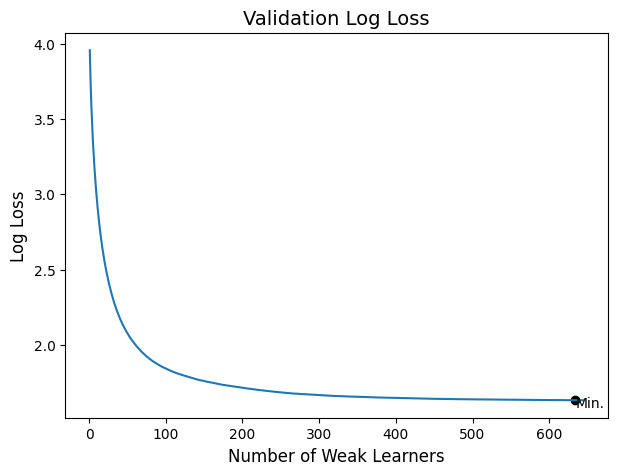

In [58]:
# Plot the Log Loss against the number of learners
plt.figure(figsize=(7,5))

plt.plot(range(1,len(XGBclf.evals_result()['validation_0']['mlogloss'])+1), 
         XGBclf.evals_result()['validation_0']['mlogloss'])
plt.scatter([range(1,len(XGBclf.evals_result()['validation_0']['mlogloss'])+1)[np.argmin(XGBclf.evals_result()['validation_0']['mlogloss'])]], 
            [np.min(XGBclf.evals_result()['validation_0']['mlogloss'])], c='k')
plt.text(range(1,len(XGBclf.evals_result()['validation_0']['mlogloss'])+1)[np.argmin(XGBclf.evals_result()['validation_0']['mlogloss'])], 
         np.min(XGBclf.evals_result()['validation_0']['mlogloss'])-.05, "Min.", fontsize=10)

plt.title("Validation Log Loss", fontsize=14)
plt.xlabel("Number of Weak Learners", fontsize=12)
plt.ylabel("Log Loss", fontsize=12)

plt.yticks(fontsize=10)
plt.xticks(fontsize=10)

plt.show()

In [59]:
# Save best model using pickle 
with open(model_path + '/xgb.pkl','wb') as f:
    pickle.dump(XGBclf, f)

# load model
with open(model_path + '/xgb.pkl', 'rb') as f:
    clf = pickle.load(f)

## Evaluate train performance

In [60]:
# Predict: 
pred_train = clf.predict(X_train_scale)

# Accuracy of train
print("Train Accuracy score:", accuracy_score(y_train_code, pred_train))

Train Accuracy score: 0.9999773586614441


In [61]:
# Predit probabilities
probs_train = clf.predict_proba(X_train_scale)

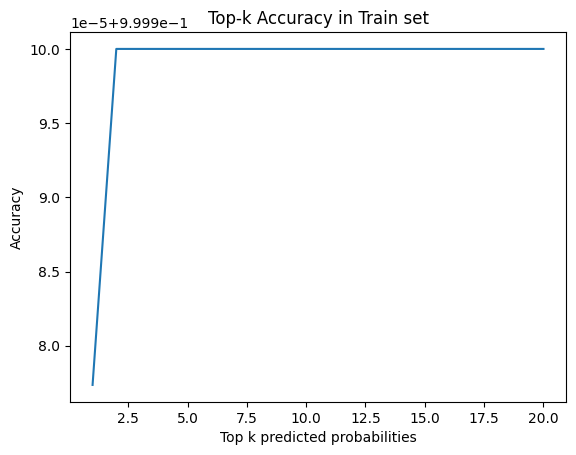

In [62]:
# Top-20 accuracy in train
top20_accuracy = topk_accuracy(20, probs_train, y_train_code)

sns.lineplot(x=range(1,21), y=top20_accuracy) 
plt.xlabel("Top k predicted probabilities")
plt.ylabel("Accuracy")
plt.title("Top-k Accuracy in Train set")
plt.show()

In [63]:
# Save top-20 accuracy on train set
top20_accuracy = topk_accuracy(20, probs_train, y_train_code)
top20_accuracy_df = pd.DataFrame(top20_accuracy, columns=['train'])
top20_accuracy_df['model'] = 'XGBoost'


## Evaluate test performance

In [64]:
# Predict: 
pred_test = clf.predict(X_test_scale)

# Accuracy of test
print("Test Accuracy score:", accuracy_score(y_test_code, pred_test))

Test Accuracy score: 0.5572534637326814


In [65]:
# Predit  probabilities
probs_test = clf.predict_proba(X_test_scale)

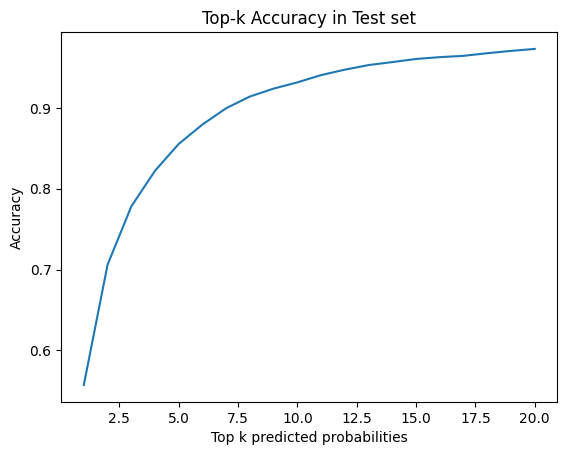

In [66]:
# Top-20 accuracy in test
top20_accuracy = topk_accuracy(20, probs_test, y_test_code)

sns.lineplot(x=range(1,21), y=top20_accuracy) 
plt.xlabel("Top k predicted probabilities")
plt.ylabel("Accuracy")
plt.title("Top-k Accuracy in Test set")
plt.show()

In [67]:
# Save top-20 accuracy on test set
top20_accuracy_df['test'] = topk_accuracy(20, probs_test, y_test_code)
top20_accuracy_df = top20_accuracy_df[['model', 'train', 'test']]
top20_accuracy_df.to_csv(top20acc_path + '/xgb.csv')

# Compare across types of model

We now return top-3 best-fit style, from which we list out top 20 wines that are most similar to the user's input by cosine similiarity.

We also compute the mean similarity score among the top 3 suggested styles. 

The similarity scores for top 3 styles and top 20 wines will help us compare modelling architects.

In [22]:
# load model - Logisitics
with open(model_path + '/logistic.pkl', 'rb') as f:
    log_model = pickle.load(f)

# load model - SVC
with open(model_path + '/linearsvc.pkl', 'rb') as f:
    svc_model = pickle.load(f)

# load model - Random Forest
with open(model_path + '/rf.pkl', 'rb') as f:
    rf_model = pickle.load(f)

# load model
with open(model_path + '/xgb.pkl', 'rb') as f:
    xgb_model = pickle.load(f)


models_dict = {'log_model': log_model,
               'svc_model': svc_model,
               'rf_model' : rf_model, 
               'xgb_model': xgb_model}

In [23]:
# Get the train set from original data
wine_emb_train = wine_emb.loc[idx_train, :]

In [ ]:
# Input - from dataset
user_input = wine_emb.iloc[60,:]['description']
test_case = X_test_scale[60, :]

# # Input - from user
# user_input = 'I want a white wine that is sweet, not bitter and have a floral note.'
# user_input = 'oaky and fruity red wine' 
# test_case = scaler.transform(embed_model.embed_documents(user_input).reshape(1,-1))

In [71]:
top3_styles_dict ={}
top20_wines_dict ={}

for m in models_dict.keys():
    print(m)
    if m =='svc_model':
        # Predit confidence score --> to be converted to probabilities
        confidence_score_test = models_dict[m].decision_function(test_case.reshape(1,-1))
        # Compute predicted probabilities after softmax
        pred_probs = np.zeros_like(confidence_score_test)
        for i, j in enumerate(confidence_score_test): 
            pred_probs[i]= softmax(j)
    else:
        pred_probs = models_dict[m].predict_proba(test_case.reshape(1,-1))  

    # Top-3 predicted styles
    top3styles_list = find_topk_styles(3, pred_probs)
    top3styles =  pd.DataFrame(top3styles_list, columns=['style3'])  
    top3styles['Model'] = m
   
    # Get wines in the top 3 styles from the train set
    narrowed_wines = wine_emb_train[wine_emb_train['style3'].isin(top3styles_list)].copy()
    
    # Compute similarity score: cosine similarity and L2-norm similarity
    sim_cosine = np.array([ dot(r.values.reshape(-1), test_case.reshape(-1) )/(norm(r.values.reshape(-1))*norm(test_case.reshape(-1) ) ) 
                           for i, r in narrowed_wines[narrowed_wines.columns[-384:]].iterrows() ], dtype='float32')
    sim_l2norm = np.array([ 1/norm( r.values.reshape(-1) - test_case.reshape(-1) ) 
                           for i, r in narrowed_wines[narrowed_wines.columns[-384:]].iterrows() ], dtype='float32')
    
    # Find top 20 wines within the top 3 styles
    top20wines = find_topk_wines(20, narrowed_wines, sim_cosine)
    top20wines['Model'] = m
    top20wines = top20wines[['Model', 'Title', 'Description', 'Similarity Score']]
    top20_wines_dict[m] = top20wines
    
    # Compute average similarity score among top 3 styles
    narrowed_wines['sim_cosine'] = sim_cosine
    top3styles = top3styles.merge( narrowed_wines.groupby('style3').sim_cosine.mean().reset_index(), on='style3' )
    top3styles.rename(columns = {'style3': 'Style', 'sim_cosine': 'Mean Similarity Score' }, inplace=True)
    top3styles = top3styles[['Model', 'Style', 'Mean Similarity Score']]
    top3_styles_dict[m] = top3styles
 

log_model
svc_model
rf_model
xgb_model


In [72]:
print(f'User input:\n"{user_input}"')
print()
for m in models_dict.keys():
    print(f'Model: {m}')
    print()
    print('Top 3 styles:')
    print()
    display(top3_styles_dict[m])
    print()
    print('Top 20 wines:')
    print()
    display(top20_wines_dict[m])
    
    top3_styles_dict[m].to_csv(top3styles_path + f'/{m}.csv', index=False)
    top20_wines_dict[m].to_csv(top20wines_path + f'/{m}.csv', index=False)

User input:
"Crisp, pristine peach and apricot notes resonate through the nose and palate of this fresh, blossomy dry Riesling. While zesty and lithe in body, ripe grapefruit and melon flavors feel supple and silky on the palate. Drink now through 2019."

Model: log_model

Top 3 styles:



,Model,Style,Mean Similarity Score
0,log_model,Chardonnay - France,0.213434
1,log_model,Portuguese White - Portugal,0.187161
2,log_model,Grüner Veltliner - Austria,0.164628



Top 20 wines:



,Model,Title,Description,Similarity Score
15998,log_model,Pascal Rollet 2013 Aux Bouthières (Pouilly-Fu...,"This wine is rich, with great fruitiness and a...",0.405836
16792,log_model,Domaine Jacques Prieur 2014 Clos de Mazeray (...,This wine is ripe with yellow fruits and rich ...,0.405245
1821,log_model,Domaine Pierre Guillemot 2015 Dessus des Golar...,"This wine is ripe, rounded with a smooth vanil...",0.391969
15227,log_model,Domaine Buisson Battault 2015 Genevrières Prem...,This wine is crisp and fruity. With acidity as...,0.378104
25033,log_model,Louis Latour 2011 Les Demoiselles (Chevalier-...,"In this generous and opulent wine, weight and ...",0.369016
11123,log_model,Roux Père et Fils 2015 Les Murgers des Denys d...,"While this wine is rich, its tight texture bri...",0.361674
33914,log_model,Philippe Colin 2014 Les Vergers Premier Cru (...,This opulent wine is full of ripe fruit and ha...,0.360996
30239,log_model,Collovray et Terrier 2012 Les Vignes de Joanny...,"A broad-based wine with rich fruit, it also ha...",0.359315
47717,log_model,Simonnet-Febvre 2015 Vaillons Premier Cru (Ch...,"This wine is fat, fruity and creamy, with just...",0.359295
45795,log_model,Domaine d'Ardhuy 2015 Petit Clos Blanc des The...,"This wine is ripe, soft and fruity. The acidit...",0.358586


Model: svc_model

Top 3 styles:



,Model,Style,Mean Similarity Score
0,svc_model,Chardonnay - France,0.213434
1,svc_model,Grüner Veltliner - Austria,0.164628
2,svc_model,Pinot Gris - France,0.177902



Top 20 wines:



,Model,Title,Description,Similarity Score
15998,svc_model,Pascal Rollet 2013 Aux Bouthières (Pouilly-Fu...,"This wine is rich, with great fruitiness and a...",0.405836
16792,svc_model,Domaine Jacques Prieur 2014 Clos de Mazeray (...,This wine is ripe with yellow fruits and rich ...,0.405245
1821,svc_model,Domaine Pierre Guillemot 2015 Dessus des Golar...,"This wine is ripe, rounded with a smooth vanil...",0.391969
15227,svc_model,Domaine Buisson Battault 2015 Genevrières Prem...,This wine is crisp and fruity. With acidity as...,0.378104
25033,svc_model,Louis Latour 2011 Les Demoiselles (Chevalier-...,"In this generous and opulent wine, weight and ...",0.369016
11123,svc_model,Roux Père et Fils 2015 Les Murgers des Denys d...,"While this wine is rich, its tight texture bri...",0.361674
33914,svc_model,Philippe Colin 2014 Les Vergers Premier Cru (...,This opulent wine is full of ripe fruit and ha...,0.360996
30239,svc_model,Collovray et Terrier 2012 Les Vignes de Joanny...,"A broad-based wine with rich fruit, it also ha...",0.359315
47717,svc_model,Simonnet-Febvre 2015 Vaillons Premier Cru (Ch...,"This wine is fat, fruity and creamy, with just...",0.359295
45795,svc_model,Domaine d'Ardhuy 2015 Petit Clos Blanc des The...,"This wine is ripe, soft and fruity. The acidit...",0.358586


Model: rf_model

Top 3 styles:



,Model,Style,Mean Similarity Score
0,rf_model,Chardonnay - France,0.213434
1,rf_model,Sauvignon Blanc - France,0.198819
2,rf_model,Portuguese White - Portugal,0.187161



Top 20 wines:



,Model,Title,Description,Similarity Score
15998,rf_model,Pascal Rollet 2013 Aux Bouthières (Pouilly-Fu...,"This wine is rich, with great fruitiness and a...",0.405836
16792,rf_model,Domaine Jacques Prieur 2014 Clos de Mazeray (...,This wine is ripe with yellow fruits and rich ...,0.405245
1821,rf_model,Domaine Pierre Guillemot 2015 Dessus des Golar...,"This wine is ripe, rounded with a smooth vanil...",0.391969
15227,rf_model,Domaine Buisson Battault 2015 Genevrières Prem...,This wine is crisp and fruity. With acidity as...,0.378104
25033,rf_model,Louis Latour 2011 Les Demoiselles (Chevalier-...,"In this generous and opulent wine, weight and ...",0.369016
11123,rf_model,Roux Père et Fils 2015 Les Murgers des Denys d...,"While this wine is rich, its tight texture bri...",0.361674
33914,rf_model,Philippe Colin 2014 Les Vergers Premier Cru (...,This opulent wine is full of ripe fruit and ha...,0.360996
30239,rf_model,Collovray et Terrier 2012 Les Vignes de Joanny...,"A broad-based wine with rich fruit, it also ha...",0.359315
47717,rf_model,Simonnet-Febvre 2015 Vaillons Premier Cru (Ch...,"This wine is fat, fruity and creamy, with just...",0.359295
45795,rf_model,Domaine d'Ardhuy 2015 Petit Clos Blanc des The...,"This wine is ripe, soft and fruity. The acidit...",0.358586


Model: xgb_model

Top 3 styles:



,Model,Style,Mean Similarity Score
0,xgb_model,Chardonnay - France,0.213434
1,xgb_model,Portuguese White - Portugal,0.187161
2,xgb_model,Champagne Blend - France,0.179740



Top 20 wines:



,Model,Title,Description,Similarity Score
15998,xgb_model,Pascal Rollet 2013 Aux Bouthières (Pouilly-Fu...,"This wine is rich, with great fruitiness and a...",0.405836
16792,xgb_model,Domaine Jacques Prieur 2014 Clos de Mazeray (...,This wine is ripe with yellow fruits and rich ...,0.405245
1821,xgb_model,Domaine Pierre Guillemot 2015 Dessus des Golar...,"This wine is ripe, rounded with a smooth vanil...",0.391969
15227,xgb_model,Domaine Buisson Battault 2015 Genevrières Prem...,This wine is crisp and fruity. With acidity as...,0.378104
25033,xgb_model,Louis Latour 2011 Les Demoiselles (Chevalier-...,"In this generous and opulent wine, weight and ...",0.369016
11123,xgb_model,Roux Père et Fils 2015 Les Murgers des Denys d...,"While this wine is rich, its tight texture bri...",0.361674
33914,xgb_model,Philippe Colin 2014 Les Vergers Premier Cru (...,This opulent wine is full of ripe fruit and ha...,0.360996
30239,xgb_model,Collovray et Terrier 2012 Les Vignes de Joanny...,"A broad-based wine with rich fruit, it also ha...",0.359315
47717,xgb_model,Simonnet-Febvre 2015 Vaillons Premier Cru (Ch...,"This wine is fat, fruity and creamy, with just...",0.359295
45795,xgb_model,Domaine d'Ardhuy 2015 Petit Clos Blanc des The...,"This wine is ripe, soft and fruity. The acidit...",0.358586
